In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class ResidualUnit(nn.Module):
    def __init__(self, in_channels, use_bn = False):
        super().__init__()
        self.use_bn = use_bn
        if self.use_bn:
            self.bn1 = nn.BatchNorm2d(in_channels)
            self.bn2 = nn.BatchNorm2d(in_channels)    
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU() # maybe not be required

    def forward(self, x):
        residual = x
        out = x
        if self.use_bn:
            out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)
        if self.use_bn:
            out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)
        out += residual
        return out

class ResidualPipeline(nn.Module):
    def __init__(self, in_channels, n_units, use_bn = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1, bias=True)
        layers = []
        for i in range(n_units):
            layers.append(ResidualUnit(64, use_bn))
        self.resnet_stack = nn.Sequential(*layers)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.resnet_stack(x)
        x = self.relu(x) # not there in original paper
        x = self.conv2(x)
        return x

class ExternalEncoder(nn.Module):
    def __init__(self, ext_dim, map_dim):
        super().__init__()
        self.map_dim = map_dim
        self.fcc1 = nn.Linear(ext_dim, 64, bias = True)
        self.fcc2 = nn.Linear(64, np.prod(map_dim), bias = True)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU() # maybe not be required
        
    def forward(self, x):
        x = self.fcc1(x)
        x = self.relu1(x)
        x = self.fcc2(x)
        x = self.relu2(x)
        return x.view(-1, *self.map_dim)
    
class STResnet(nn.Module):
    def __init__(self, c_channel, p_channel, t_channel, n_residual_units, ext_dim, map_dim, use_bn = False):
        super().__init__()
        self.e_pipe = ExternalEncoder(ext_dim, map_dim)
        self.c_pipe = ResidualPipeline(c_channel, n_residual_units, use_bn)
        self.p_pipe = ResidualPipeline(p_channel, n_residual_units, use_bn)
        self.t_pipe = ResidualPipeline(t_channel, n_residual_units, use_bn)
        # 1 dimension for batch processing, this class cannot process unbatched data
        self.w_c = nn.Parameter(torch.randn(1, *map_dim))
        self.w_p = nn.Parameter(torch.randn(1, *map_dim))
        self.w_t = nn.Parameter(torch.randn(1, *map_dim))
        self.tanh = nn.Tanh()
        
    def forward(self, x_c, x_p, x_t, x_e):
        y_e = self.e_pipe(x_e)
        y_c = self.c_pipe(x_c)
        y_p = self.p_pipe(x_p)
        y_t = self.t_pipe(x_t)
        # Fusion: Eliment wise product (Hadamard Product)
        y = self.w_c*y_c + self.w_p*y_p + self.w_t*y_t
        y = self.tanh(y+y_e)
        return y

In [3]:
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from TaxiBJ import TaxiBJDataset
n_closeness = 4
n_period = 1
n_trend = 1
flow_ch = 2 # Inflow and Outflow
n_residual_units = 12
map_dim = (flow_ch, 32, 32) # Specific to dataset
ext_dim = 27
taxibj_dataset_train = TaxiBJDataset('./Datasets/TaxiBJ/',n_closeness,n_period,n_trend,0.8,True)
taxibj_dataset_test = TaxiBJDataset('./Datasets/TaxiBJ/',n_closeness,n_period,n_trend,0.8,False)

min: 0.0 max: 1292.0
min: -15.1 max: 36.1
min: 0.0 max: 31.32
min: 0.0 max: 1292.0
min: -15.1 max: 36.1
min: 0.0 max: 31.32


In [6]:
from tqdm import tqdm
mmn = taxibj_dataset_train.mmn_flow

def train_epoch(model,dataloader,loss_fn,optimizer):
    train_loss = 0.0
    model.train()
    for x_c, x_p, x_t, x_e, y in tqdm(dataloader):
        optimizer.zero_grad()
        output = model(x_c, x_p, x_t, x_e)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss
  
def valid_epoch(model,dataloader,loss_fn):
    valid_loss = 0.0
    model.eval()
    for x_c, x_p, x_t, x_e, y in dataloader:
        output = model(x_c, x_p, x_t, x_e)
        loss = loss_fn(output, y)
        valid_loss += loss.item()
    return valid_loss

In [4]:
import torch.optim as optim
batch_size = 32
num_epochs = 50

train_size = int(0.9 * len(taxibj_dataset_train))
valid_size = len(taxibj_dataset_train) - train_size
train_idx, valid_idx = random_split(range(len(taxibj_dataset_train)), [train_size, valid_size])
train_loader = DataLoader(taxibj_dataset_train, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx))
valid_loader = DataLoader(taxibj_dataset_train, batch_size=batch_size, sampler=SubsetRandomSampler(valid_idx))

model = STResnet(n_closeness*flow_ch,n_period*flow_ch,n_trend*flow_ch,n_residual_units,ext_dim,map_dim,True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fun = nn.MSELoss(reduction = 'sum')

In [5]:
history = {'train_loss': [], 'valid_loss': []}
for epoch in range(num_epochs):
    train_loss=train_epoch(model,train_loader,loss_fun,optimizer)/len(train_loader.sampler)
    valid_loss=valid_epoch(model,valid_loader,loss_fun)/len(valid_loader.sampler)
    print("Epoch:{}/{} | Training Loss: {} | Validation Loss: {}".format(epoch + 1, num_epochs, train_loss, valid_loss))
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    if train_loss < 0.5:
        break  

100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [03:22<00:00,  2.22it/s]


Epoch:1/50 | Training Loss: 79.62605897732814 | Validation Loss: 11.933513673503747


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.11it/s]


Epoch:2/50 | Training Loss: 9.315340107638415 | Validation Loss: 6.937055674682694


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.13it/s]


Epoch:3/50 | Training Loss: 6.189759808498713 | Validation Loss: 5.179315736082461


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.11it/s]


Epoch:4/50 | Training Loss: 4.78857136057305 | Validation Loss: 4.054456715875499


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.13it/s]


Epoch:5/50 | Training Loss: 3.9780718059276374 | Validation Loss: 3.62068280387907


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:6/50 | Training Loss: 3.5119124743532892 | Validation Loss: 3.193040950170319


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.13it/s]


Epoch:7/50 | Training Loss: 3.150612756524082 | Validation Loss: 2.9477006147863265


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:8/50 | Training Loss: 2.8245581954446686 | Validation Loss: 2.596143490068624


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.13it/s]


Epoch:9/50 | Training Loss: 2.739855311002777 | Validation Loss: 2.591257565625747


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:10/50 | Training Loss: 2.5438865697626287 | Validation Loss: 2.5319507235147234


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.13it/s]


Epoch:11/50 | Training Loss: 2.395131705958753 | Validation Loss: 2.2450115558657604


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.13it/s]


Epoch:12/50 | Training Loss: 2.324339927463133 | Validation Loss: 2.2405113685741256


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:13/50 | Training Loss: 2.2499763116274627 | Validation Loss: 2.0909377166840915


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.13it/s]


Epoch:14/50 | Training Loss: 2.1747087303509494 | Validation Loss: 2.0278969924250494


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:15/50 | Training Loss: 2.086661102191142 | Validation Loss: 2.0927880131796504


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:16/50 | Training Loss: 2.077262478389683 | Validation Loss: 1.987746082441637


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:17/50 | Training Loss: 2.0294624870412017 | Validation Loss: 1.9491346479206346


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:18/50 | Training Loss: 1.9705102106311847 | Validation Loss: 1.912338321128588


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:19/50 | Training Loss: 1.9554123832479722 | Validation Loss: 2.0175980503639477


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.13it/s]


Epoch:20/50 | Training Loss: 1.912850809557283 | Validation Loss: 1.9464906041839447


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:21/50 | Training Loss: 1.8817243793801801 | Validation Loss: 2.164199470729566


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:26<00:00,  3.09it/s]


Epoch:22/50 | Training Loss: 1.8500788004494813 | Validation Loss: 1.8623337043209767


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.13it/s]


Epoch:23/50 | Training Loss: 1.8270068231185923 | Validation Loss: 1.891810796978173


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.12it/s]


Epoch:24/50 | Training Loss: 1.7986936765786337 | Validation Loss: 1.9170958406469796


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:25/50 | Training Loss: 1.7954263258910261 | Validation Loss: 1.759743226154913


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:26/50 | Training Loss: 1.771605332593185 | Validation Loss: 1.97509704040975


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:27/50 | Training Loss: 1.748386797381106 | Validation Loss: 1.8352479008997276


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.13it/s]


Epoch:28/50 | Training Loss: 1.7274359869786542 | Validation Loss: 1.840680036056652


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.15it/s]


Epoch:29/50 | Training Loss: 1.7431962864860107 | Validation Loss: 1.7472540146105


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.13it/s]


Epoch:30/50 | Training Loss: 1.6878782897531983 | Validation Loss: 1.7841515627395497


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:31/50 | Training Loss: 1.6715294050801361 | Validation Loss: 1.7363879326428664


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:32/50 | Training Loss: 1.692270557242865 | Validation Loss: 1.7862194099378645


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:33/50 | Training Loss: 1.6439370770136383 | Validation Loss: 1.6770169144117282


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.13it/s]


Epoch:34/50 | Training Loss: 1.6332219772661856 | Validation Loss: 1.7065099320012829


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:35/50 | Training Loss: 1.630295867318953 | Validation Loss: 1.6929742712504259


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:36/50 | Training Loss: 1.6190697009909765 | Validation Loss: 1.6602015947730056


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:37/50 | Training Loss: 1.6188706615034203 | Validation Loss: 1.773753260256497


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:38/50 | Training Loss: 1.602612943038395 | Validation Loss: 1.7041512273819408


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.15it/s]


Epoch:39/50 | Training Loss: 1.5976187742859265 | Validation Loss: 1.8033831714839674


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.13it/s]


Epoch:40/50 | Training Loss: 1.5699034755785417 | Validation Loss: 1.6178278229507466


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:41/50 | Training Loss: 1.5803813036843783 | Validation Loss: 1.9680234162548509


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.13it/s]


Epoch:42/50 | Training Loss: 1.5227913283004513 | Validation Loss: 2.0374475858928855


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:43/50 | Training Loss: 1.515682730223686 | Validation Loss: 1.6146278789129744


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.14it/s]


Epoch:44/50 | Training Loss: 1.4961253282752307 | Validation Loss: 1.7549935463215975


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.12it/s]


Epoch:45/50 | Training Loss: 1.522880668899586 | Validation Loss: 1.5922848648495145


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.12it/s]


Epoch:46/50 | Training Loss: 1.504153423996337 | Validation Loss: 1.825288416443395


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.12it/s]


Epoch:47/50 | Training Loss: 1.496634623850316 | Validation Loss: 1.6589240435506223


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:23<00:00,  3.13it/s]


Epoch:48/50 | Training Loss: 1.4816963041719735 | Validation Loss: 1.6263377103912697


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.12it/s]


Epoch:49/50 | Training Loss: 1.4931504408882497 | Validation Loss: 1.682601707853777


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:24<00:00,  3.13it/s]


Epoch:50/50 | Training Loss: 1.4635312722189107 | Validation Loss: 1.5577349589856229


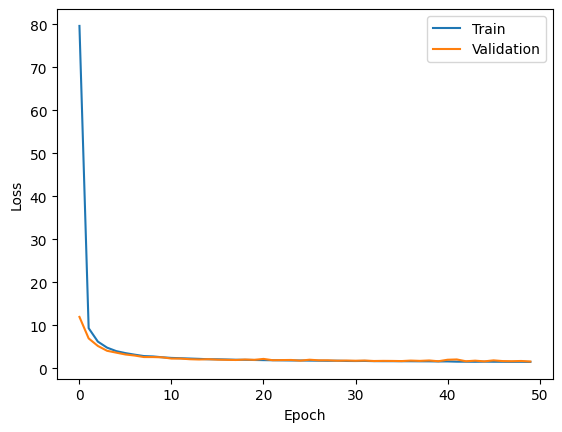

In [11]:
import matplotlib.pyplot as plt
torch.save(model,'Checkpoints/TaxiBJ/k_fold_stresnet.pt')
fig = plt.figure()
plt.plot(list(range(len(history['train_loss']))), history['train_loss'], label='Train')
plt.plot(list(range(len(history['valid_loss']))), history['valid_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [7]:
import math
test_loader = DataLoader(taxibj_dataset_test, batch_size=batch_size)
test_loss = 0.0
model = torch.load('Checkpoints/TaxiBJ/k_fold_stresnet.pt')
model.eval()
for x_c, x_p, x_t, x_e, y in test_loader:
    output = mmn.inverse_transform(model(x_c, x_p, x_t, x_e))
    loss = loss_fun(output, mmn.inverse_transform(y))
    test_loss += loss.item()
rmse_loss = math.sqrt(test_loss/len(test_loader.sampler))
print('Map Root Mean Square Loss: ', rmse_loss)
rmse_loss = math.sqrt(test_loss/(len(test_loader.sampler)*np.prod(map_dim)))
print('Grid Root Mean Square Loss: ', rmse_loss)

Map Root Mean Square Loss:  810.2561083839684
Grid Root Mean Square Loss:  17.904299648003946


In [ ]:
flow_pred = np.zeros((len(taxibj_dataset_test),*map_dim))
flow_org = np.zeros((len(taxibj_dataset_test),*map_dim))
for i in range(len(taxibj_dataset_test)):
    x_c, x_p, x_t, x_e, y = taxibj_dataset_test[i]
    x_e = torch.unsqueeze(x_e, 0)
    x_c = torch.unsqueeze(x_c, 0)
    x_p = torch.unsqueeze(x_p, 0)
    x_t = torch.unsqueeze(x_t, 0)    
    y_pred = model(x_c, x_p, x_t, x_e)
    flow_org[i,:,:,:] = mmn.inverse_transform(y).cpu().detach().numpy()[:,:,:]
    flow_pred[i,:,:,:] = mmn.inverse_transform(y_pred).cpu().detach().numpy()[:,:,:]

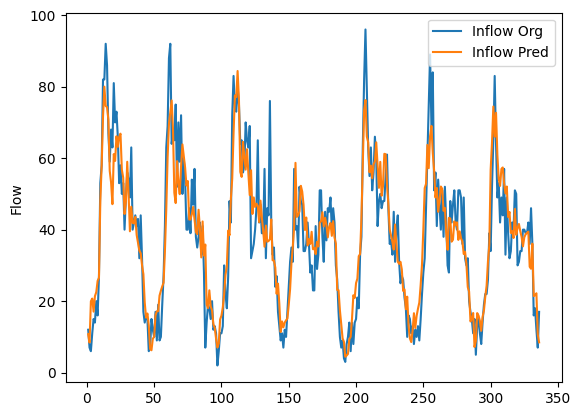

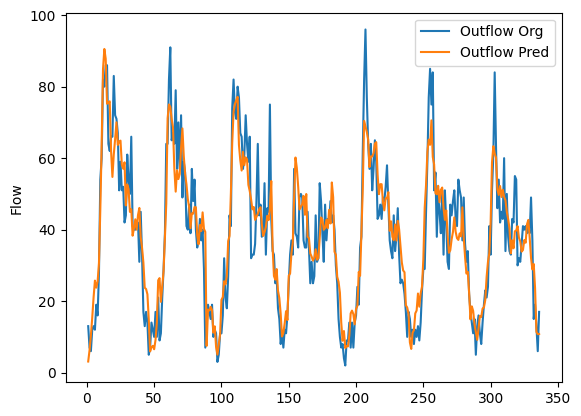

In [8]:
x, y = 10, 10

fig = plt.figure()
in_flow_org = flow_org[24*2*7*0:24*2*7*1,0,x,y]
in_flow_pred = flow_pred[24*2*7*0:24*2*7*1,0,x,y]
t = np.linspace(1, 24*2*7*1, num=24*2*7*1)
plt.plot(t,in_flow_org,label='Inflow Org')
plt.plot(t,in_flow_pred,label='Inflow Pred')
plt.ylabel('Flow')
plt.legend(loc='upper right')
plt.show()

fig = plt.figure()
out_flow_org = flow_org[24*2*7*0:24*2*7*1,1,x,y]
out_flow_pred = flow_pred[24*2*7*0:24*2*7*1,1,x,y]
t = np.linspace(1, 24*2*7*1, num=24*2*7*1)
plt.plot(t,out_flow_org,label='Outflow Org')
plt.plot(t,out_flow_pred,label='Outflow Pred')
plt.ylabel('Flow')
plt.legend(loc='upper right')
plt.show()